c:\Users\Pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
868/868 ━━━━━━━━━━━━━━━━━━━━ 37s 40ms/step - accuracy: 0.5894 - loss: 1.3963 - val_accuracy: 0.9637 - val_loss: 0.1263
Epoch 2/10
868/868 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - accuracy: 0.9848 - loss: 0.0545 - val_accuracy: 0.9869 - val_loss: 0.0476
Epoch 3/10
868/868 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - accuracy: 0.9938 - loss: 0.0214 - val_accuracy: 0.9914 - val_loss: 0.0345
Epoch 4/10
868/868 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - accuracy: 0.9937 - loss: 0.0219 - val_accuracy: 0.9935 - val_loss: 0.0255
Epoch 5/10
868/868 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - accuracy: 0.9958 - loss: 0.0156 - val_accuracy: 0.9974 - val_loss: 0.0119
Epoch 6/10
868/868 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - accuracy: 0.9968 - loss: 0.0114 - val_accuracy: 0.9954 - val_loss: 0.0202
Epoch 7/10
868/868 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - accuracy: 0.9982 - loss: 0.0075 - val_accuracy: 0.9967 - val_loss: 0.0123
Epoch 8/10
868/868 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - accuracy: 0.9988 - loss: 0.0035 - 

Accuracy on validation set: 98.01%


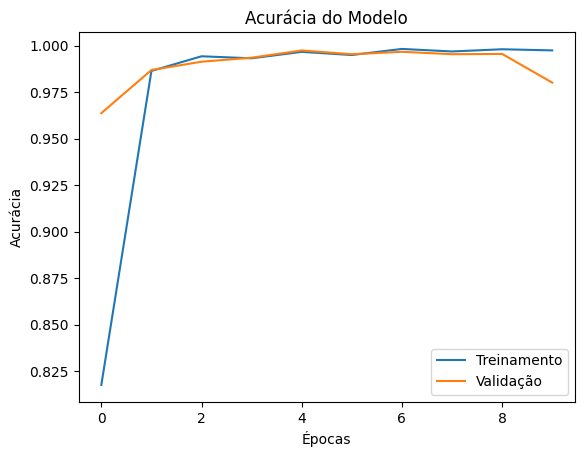

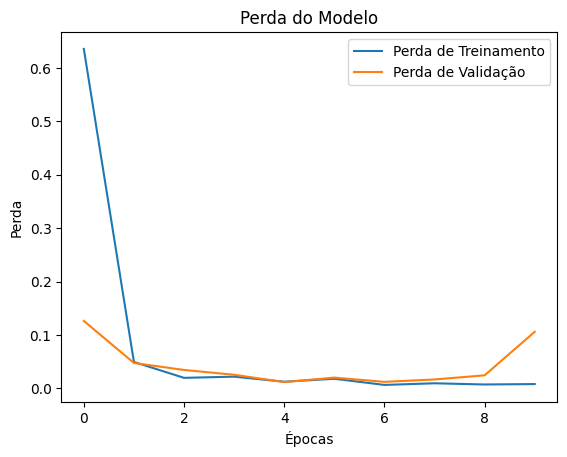

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import keras_tuner as kt
import tensorflow as tf
import numpy as np

In [ ]:
# Carregar os dados preparados
x_treino = np.load('x_treino.npy')  # Carrega as imagens de treinamento
y_treino = np.load('y_treino.npy')  # Carrega os rótulos de treinamento

x_validacao = np.load('x_validacao.npy')  # Carrega as imagens de validação
y_validacao = np.load('y_validacao.npy')  # Carrega os rótulos de validação

x_teste = np.load('x_teste.npy')  # Carrega as imagens de teste
y_teste = np.load('y_teste.npy')  # Carrega os rótulos de teste

In [ ]:
# Convertendo os rótulos para one-hot encoding
y_treino = to_categorical(y_treino, num_classes=21)  
y_validacao = to_categorical(y_validacao, num_classes=21)
y_teste = to_categorical(y_teste, num_classes=21)

In [ ]:
# Função para criar o modelo parametrizado
def build_model(hp):
    model = models.Sequential()
    
    # Camada Convolucional 1
    model.add(layers.Conv2D(
        filters=hp.Choice('filters_conv1', [32, 64]),
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(64, 64, 1)
    ))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Camada Convolucional 2
    model.add(layers.Conv2D(
        filters=hp.Choice('filters_conv2', [64, 128]),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(layers.MaxPooling2D((2, 2)))

    # Camada Flatten
    model.add(layers.Flatten())
    
    # Camada densa
    model.add(layers.Dense(
        units=hp.Choice('units_dense', [64, 128]),
        activation='relu'
    ))
    
    # Camada de saída
    model.add(layers.Dense(21, activation='softmax'))

    # Compilação
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# Configurar o KerasTuner com parâmetros otimizados
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,  
    factor=3,     
    directory='grid_search_fast',
    project_name='cnn_fast'
)

# Callback para interromper caso não haja melhora
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

# Realizar o Grid Search
tuner.search(x_treino[:5000], y_treino[:5000], 
             epochs=5,
             validation_data=(x_validacao[:1000], y_validacao[:1000]),
             callbacks=[stop_early])

# Obter os melhores hiperparâmetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Melhores Hiperparâmetros:
- Filtros na Camada 1: {best_hps.get('filters_conv1')}
- Filtros na Camada 2: {best_hps.get('filters_conv2')}
- Unidades na Camada Densa: {best_hps.get('units_dense')}
- Taxa de Aprendizado: {best_hps.get('learning_rate')}
""")

In [ ]:
# Treinar modelo com os melhores hiperparâmetros
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    x_treino, y_treino,
    epochs=10,
    validation_data=(x_validacao, y_validacao)
)

In [ ]:
# Avaliar o modelo no conjunto de validação
val_loss, val_acc = best_model.evaluate(x_validacao, y_validacao)
print(f"\nAcurácia no conjunto de validação: {val_acc * 100:.2f}%")

# Avaliar o modelo no conjunto de teste
teste_loss, teste_acc = best_model.evaluate(x_teste, y_teste)
print(f"Acurácia no conjunto de teste: {teste_acc * 100:.2f}%")